In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import style
from scipy.stats import norm

# Styles
style.use('fivethirtyeight')
plt.rcParams['figure.facecolor'] = '#FFFFFF'
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['font.size'] = 18

In [2]:
# Functions
#https://dfrieds.com/data-visualizations/how-format-large-tick-values.html

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

In [3]:
# Load Data
dfs = pd.read_csv('../../Datos/LQI/20m/raw_data_run1--28.csv', 
                       index_col ='Date', 
                       parse_dates = True) 

cantidad=len(dfs)
print(cantidad)

# Split data into train / test sets 
#Hallar el 55%-65%-75%
entrenamiento = int((cantidad/100)*55)
entrenamiento2 = int((cantidad/100)*65)
entrenamiento3 = int((cantidad/100)*75)
testing1 = int((cantidad/100)*10)
testing2 = int((cantidad/100)*25)
print(entrenamiento, testing1)

#datos de entrenamiento y testing con Walk Forward Validation 
df=dfs[:entrenamiento]
sales = df['LQI']

test=dfs[entrenamiento:entrenamiento2]
test=test.reset_index(drop="true")

8064
4435 806


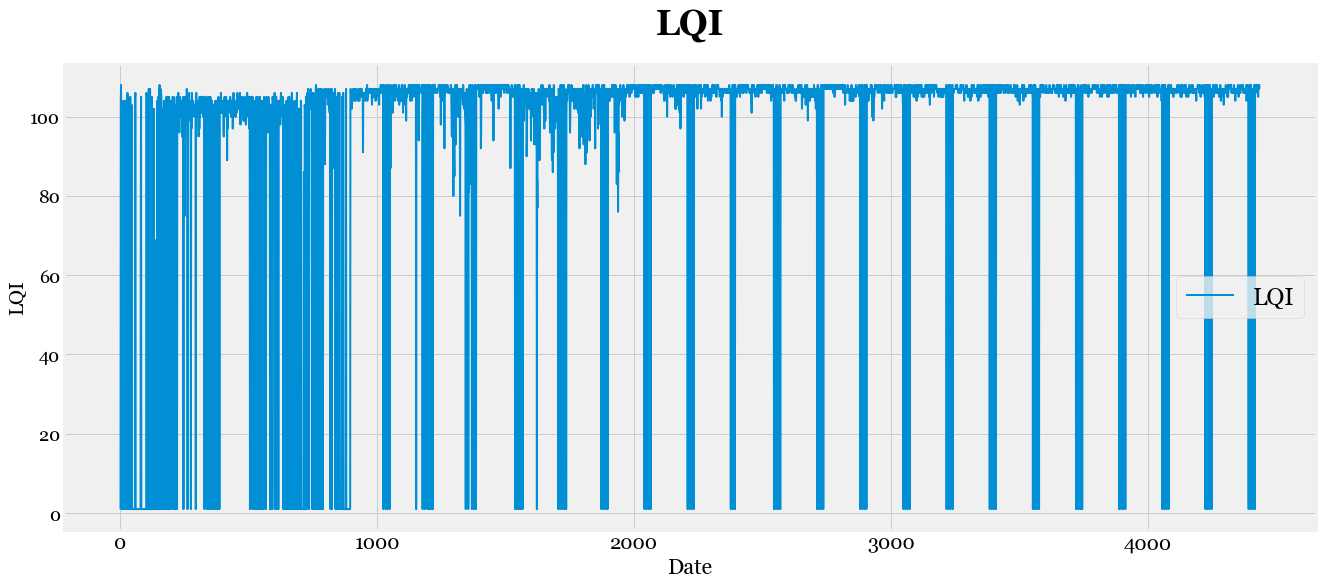

In [4]:
# Sales
smoothed = sales.rolling(window=6).mean()
smoothed = smoothed.dropna()

fig, ax = plt.subplots(figsize=(20,8))

ax.set_title('LQI', fontsize=35, fontweight='bold', pad=30)
ax.set_ylabel('LQI', fontsize=20)
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

for t in ax.xaxis.get_major_ticks():
    t.label.set_fontsize(20) 

df['LQI'].plot(ax=ax, linewidth=2, label="LQI")
ax.legend(fontsize=24)

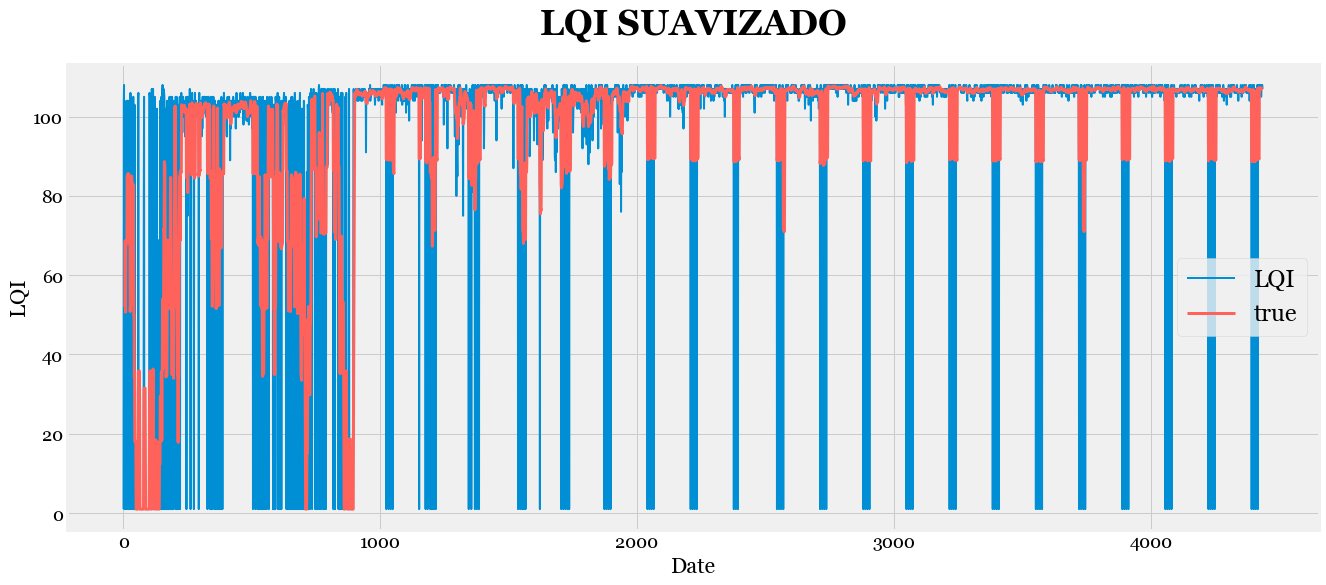

In [5]:
# Total Sales with Smoothing
smoothed = sales.rolling(window=6).mean()
smoothed = smoothed.dropna()

fig, ax = plt.subplots(figsize=(20,8))

ax.set_title('LQI SUAVIZADO', fontsize=35, fontweight='bold', pad=30)
ax.set_ylabel('LQI')
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

sales.plot(ax=ax, linewidth=2, label="LQI")
smoothed.plot(ax=ax, linewidth=3, color='#FF625B', label="true")

ax.legend(fontsize=24)

Text(0.5, 1.0, 'Distribution of groups of 30')

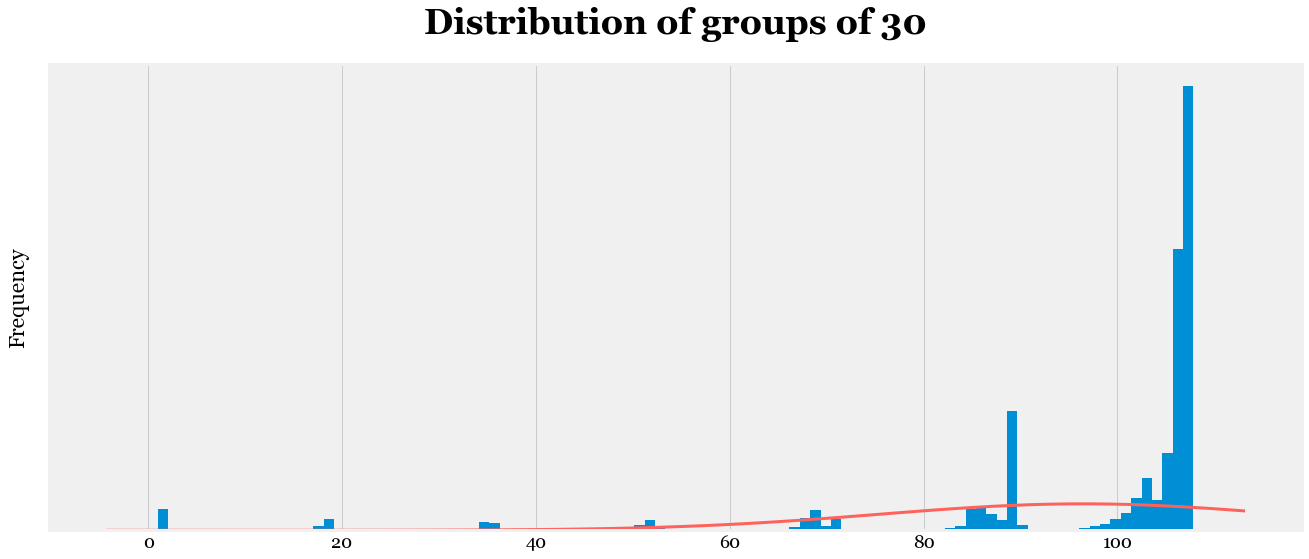

In [6]:
# Distribution of Weekly Sales
fig, ax = plt.subplots(figsize=(20,8))

smoothed.plot.hist(bins=100, density=True, ax=ax)

# Plot the pdf
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 60)
p = norm.pdf(x, smoothed.mean(), smoothed.std())
ax.plot(x, p, color='#FF625B', linewidth=3)
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

ax.set_yticks([])
ax.set_ylabel('Frequency', labelpad=20)
ax.set_title('Distribution of groups of 30', fontsize=35, fontweight='bold', pad=30)

In [7]:
smoothed

Date
6        52.000000
7        68.666667
8        68.500000
9        50.666667
10       67.500000
           ...    
4431    106.833333
4432    107.166667
4433    107.166667
4434    107.166667
4435    107.000000
Name: LQI, Length: 4430, dtype: float64

In [8]:
smoothed[entrenamiento-1]

107.16666666666667

Text(0.5, 1.05, 'Simulate Random Walks')

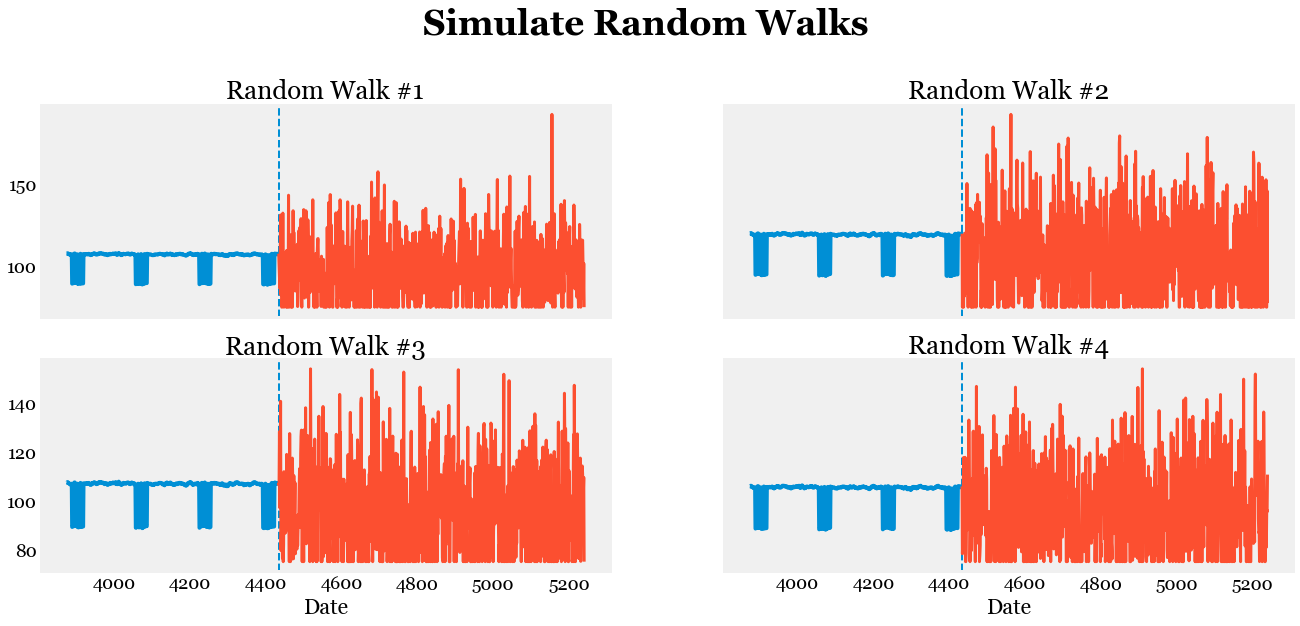

In [9]:
# A random walk
last_sale = smoothed[entrenamiento-1]
num_weeks = testing1

mu = smoothed.mean()
std = smoothed.std()

index = range(entrenamiento-1,entrenamiento2)

def make_sim_plot(ax=ax, title=''):
    sales_series = []
    sales_series.append(last_sale)

    for week in range(num_weeks):
        weekly_sales = np.random.normal(mu, std)
        if weekly_sales < 75:
            weekly_sales = 75;
        sales_series.append(weekly_sales)
    s = pd.Series(sales_series, index=index)
    ax.set_title(title)
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
    ax.axvline(x=s.index.min(), linestyle='dashed', linewidth=2)

    smoothed[-562:].plot(ax=ax)
    s.plot(ax=ax, linewidth=3)

    
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2, figsize=(20,8))

make_sim_plot(ax1, title='Random Walk #1')
make_sim_plot(ax2, title='Random Walk #2')
make_sim_plot(ax3, title='Random Walk #3')
make_sim_plot(ax4, title='Random Walk #4')
ax2.set_yticks([])
ax4.set_yticks([])
ax2.set_xticks([])
ax2.set_xlabel('')
ax1.set_xticks([])
ax1.set_xlabel('')

ax1.grid(None)
ax2.grid(None)
ax3.grid(None)
ax4.grid(None)

fig.suptitle('Simulate Random Walks', fontsize=35, fontweight='bold', y=1.05)

In [10]:
num_simulations = 50000  #n simulaciones

# Creating an array, 
price_list = np.zeros((testing1,num_simulations))
price_list[0]=smoothed[entrenamiento-1]
price_list

array([[107.16666667, 107.16666667, 107.16666667, ..., 107.16666667,
        107.16666667, 107.16666667],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [11]:
price_list[0,0]

107.16666666666667

Text(0.5, 0.98, 'Simulations of 1,000 Random Walks')

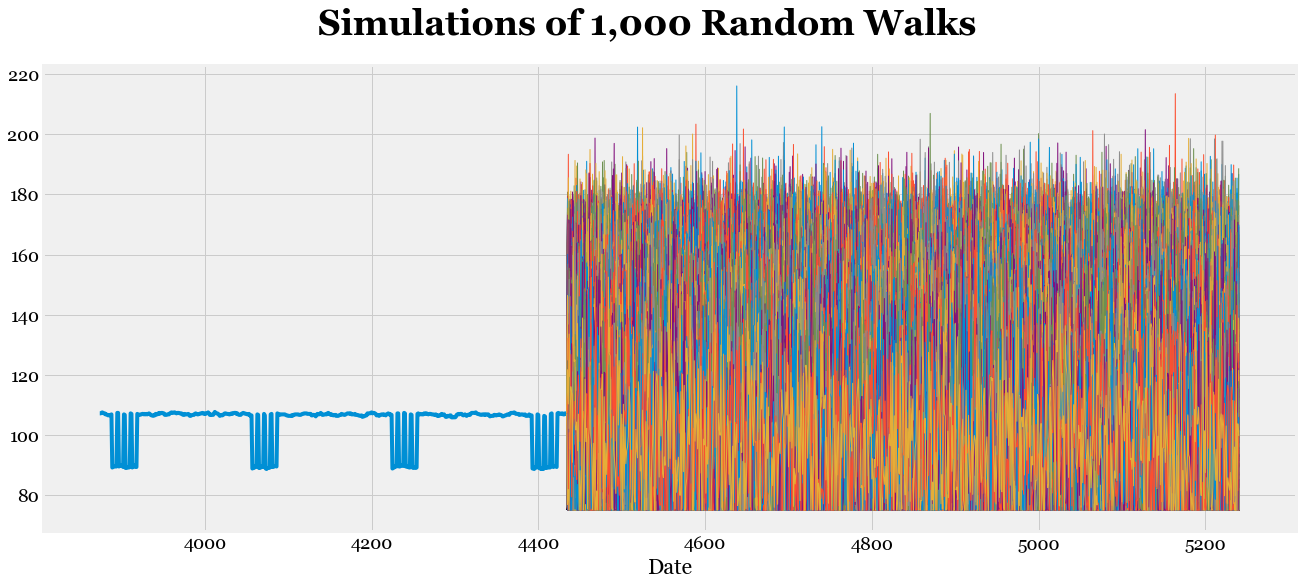

In [12]:
# Many, many random walks
num_simulations = 50000   #n simulaciones
iterations=num_simulations
num_weeks = testing1

last_sale = smoothed[entrenamiento-1]
mu = smoothed.mean()
std = smoothed.std()

index = range(entrenamiento-1,entrenamiento2)

simulation_df = pd.DataFrame()


sales_2018 = []

for sim in range(num_simulations):
    sales_series = []
    sales_series.append(last_sale)

    for week in range(num_weeks):
        weekly_sales = np.random.normal(mu, std)
        if weekly_sales < 75:
            weekly_sales = 75
        #aprovechar el for de semanas para llenar una matriz con las predicciones
        price_list[week,sim]=weekly_sales;
        #print( price_list[week,sim]);
        sales_series.append(weekly_sales)
    
    sales_2018.append(np.sum(sales_series))
    
    simulation_df[sim] = sales_series
    

simulation_df.index = index


fig, ax = plt.subplots(figsize=(20,8))
smoothed[-562:].plot(ax=ax)
simulation_df.plot(ax=ax, legend=False, linewidth=1)

ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
fig.suptitle('Simulations of 1,000 Random Walks', fontsize=35, fontweight='bold')

In [13]:
print(price_list)

[[ 84.91390975 110.26697343 106.46132529 ...  85.76032851  95.14578299
   76.88472459]
 [ 75.         106.26297107 119.64315029 ...  75.          75.
   81.84909082]
 [ 75.          75.         115.30036065 ...  87.64073108 100.74231487
   75.        ]
 ...
 [ 93.12687341  75.          75.         ... 107.2986639  103.38225189
   75.        ]
 [ 75.          98.45034431  86.7792553  ...  85.13876489  81.46960915
  103.71487796]
 [116.68219695  94.87600885  99.48808529 ... 105.97997293 100.97864335
   99.71193106]]


Text(0.5, 0.98, 'Total LQI FORECAST')

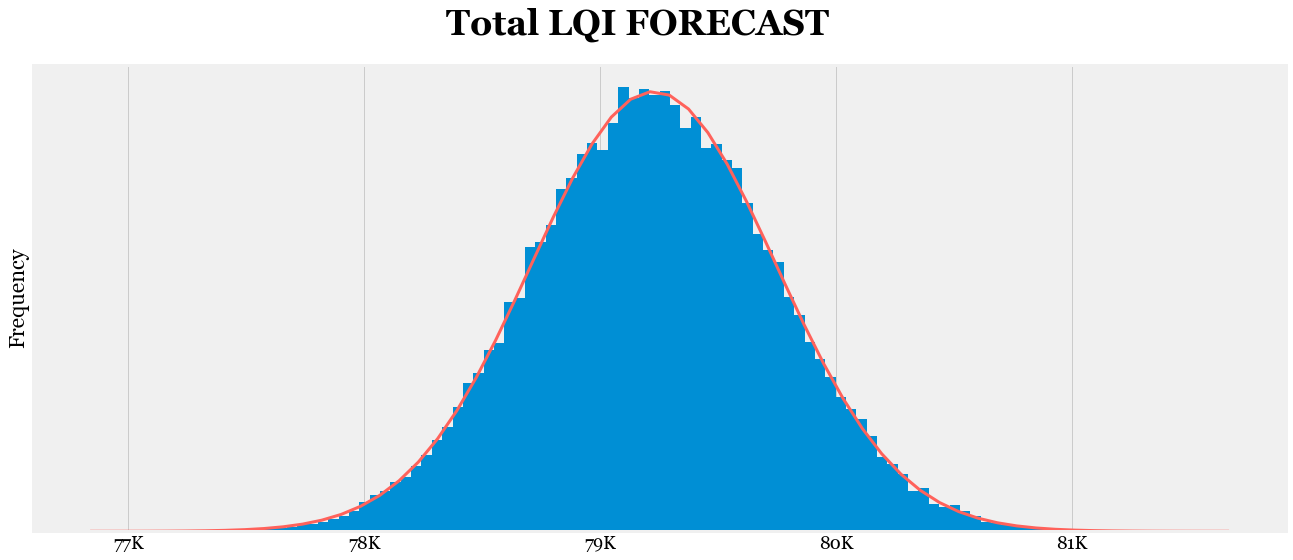

In [14]:
#Random walk total sales

fig, ax = plt.subplots(figsize=(20,8))
simulations_2018 = pd.Series(data=sales_2018)
simulations_2018.plot.hist(bins=100, ax=ax, density=True)

# Plot the pdf
xmin, xmax = plt.xlim()
mean = simulations_2018.mean()
std = simulations_2018.std()

x = np.linspace(xmin, xmax, 60)
p = norm.pdf(x, mean, std)
ax.plot(x, p, color='#FF625B', linewidth=3)
ax.set_yticks([])
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
fig.suptitle('Total LQI FORECAST', fontsize=35, fontweight='bold')

Text(0.5, 0.98, 'TOTAL LQI FORECAST Normal Distribution')

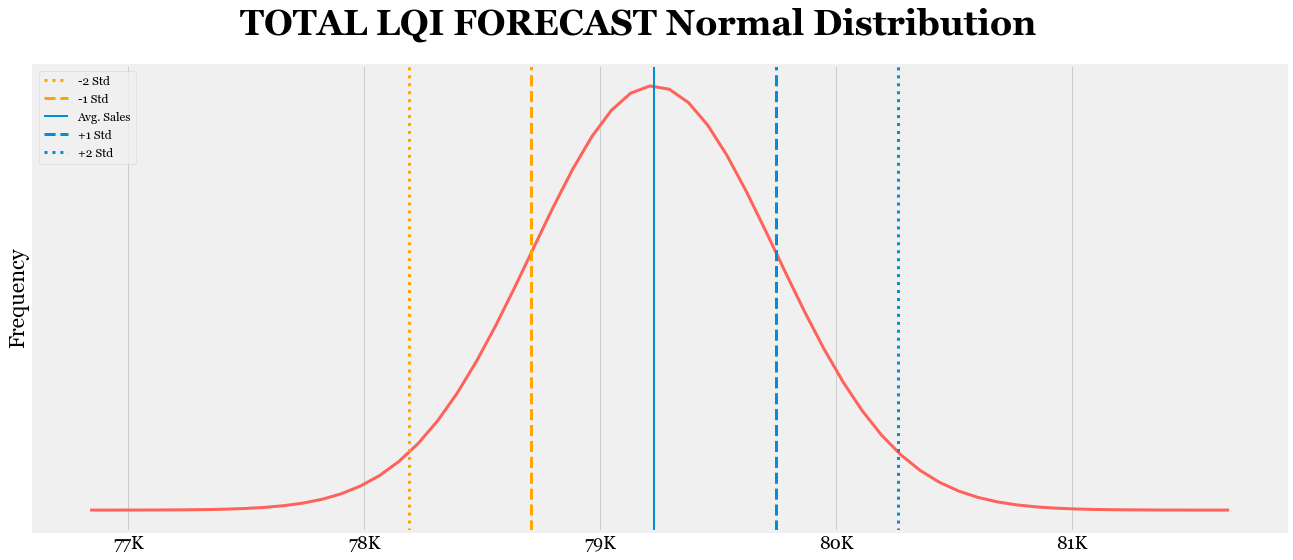

In [15]:
# 2018 Sales normal distribution
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(x, p, color='#FF625B', linewidth=3)

ax.set_yticks([])
ax.set_ylabel('Frequency')

ax.axvline(mean - (std * 2), linewidth=3, label='-2 Std', linestyle='dotted', color='orange')
ax.axvline(mean - std, linewidth=3, label='-1 Std', linestyle='dashed', color='orange')
ax.axvline(mean, linewidth=2, label="Avg. Sales")
ax.axvline(mean + std, linewidth=3, label='+1 Std', linestyle='dashed')
ax.axvline(mean + (std * 2), linewidth=3, label='+2 Std', linestyle='dotted')

ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax.legend(fontsize=12, loc='upper left')
fig.suptitle('TOTAL LQI FORECAST Normal Distribution', fontsize=35, fontweight='bold')

In [16]:
# Ask Questions

from scipy.stats import norm
#mean + std * norm.
#mean + (std * norm.ppf(.25))
print("It's highly likely that you LQI will be between ${:,.0f} and ${:,.0f}.".format(mean + (2 * -std), mean + (2 * std)))
print("There's a 25% chance that LQI will be less than {:,.0f}.".format(mean + (std * norm.ppf(.25))))

It's highly likely that you LQI will be between $78,190 and $80,265.
There's a 25% chance that LQI will be less than 78,878.


In [17]:
simulation_df

,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
4434,107.166667,107.166667,107.166667,107.166667,107.166667,107.166667,107.166667,107.166667,107.166667,107.166667,...,107.166667,107.166667,107.166667,107.166667,107.166667,107.166667,107.166667,107.166667,107.166667,107.166667
4435,84.913910,110.266973,106.461325,131.686845,77.032249,88.870570,123.435875,78.632826,136.404338,143.300063,...,104.977174,89.044962,114.184266,121.715824,101.030974,106.871579,89.149121,85.760329,95.145783,76.884725
4436,75.000000,106.262971,119.643150,105.621571,99.447271,75.000000,76.018432,102.449437,81.525503,89.408507,...,75.000000,75.786397,103.437405,110.300725,75.000000,86.802115,75.000000,75.000000,75.000000,81.849091
4437,75.000000,75.000000,115.300361,126.439644,96.723400,78.624997,101.820399,102.221717,103.198349,100.818317,...,102.783674,75.000000,96.967521,133.558215,81.114959,104.983150,101.934829,87.640731,100.742315,75.000000
4438,108.395828,77.683302,75.000000,107.018017,103.835415,89.730892,102.088460,114.863123,98.421415,94.679998,...,87.822726,84.903308,122.524413,111.389388,119.197835,98.929071,88.300821,94.838500,95.335321,103.830296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236,75.000000,92.357389,105.921401,85.092187,129.437479,82.094955,75.000000,88.970740,75.000000,98.623445,...,93.751741,96.685846,83.942508,75.000000,89.639368,83.185292,106.826257,94.266793,97.843032,79.711712
5237,88.645004,81.497381,117.199158,75.000000,90.198715,102.174661,117.340522,75.337855,104.827971,82.564217,...,76.944534,99.142473,130.907426,112.200071,107.537213,80.589880,130.116250,101.907474,110.335417,130.832627
5238,93.126873,75.000000,75.000000,79.742548,99.260318,101.749416,75.000000,113.841928,106.683719,90.346557,...,103.633116,82.174129,109.335769,75.000000,75.000000,75.000000,124.085856,107.298664,103.382252,75.000000
5239,75.000000,98.450344,86.779255,104.692742,120.744942,75.000000,102.977366,103.078806,116.358928,117.699666,...,75.000000,96.777677,86.827995,80.318092,99.798251,115.418822,75.000000,85.138765,81.469609,103.714878


In [18]:
print(test)
test

     LQI
0    107
1    107
2    106
3    105
4    108
..   ...
801  108
802  106
803  106
804  105
805    1

[806 rows x 1 columns]


,LQI
0,107
1,107
2,106
3,105
4,108
...,...
801,108
802,106
803,106
804,105


In [19]:
#HALLLAR LA MEJOR SIMULACIÓN MEDIANTE RMSE Y plotearla con una cantidad de datos de test

# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 

#for para comparar todas las predicciones

menor=5;
index=0;

for i in range(0, iterations):
    prediction = rmse(test["LQI"], price_list[:, i]) 
    if prediction<menor:
        menor=prediction
        index=i
        
        
print(menor, index)

5 0


In [20]:
#unir el training 0-55% con la prediccion 55-65%

In [21]:
#convertir a dataframe las predicciones
predictions1=pd.DataFrame(price_list[:,index])
predictions1

,0
0,84.913910
1,75.000000
2,75.000000
3,108.395828
4,78.298880
...,...
801,75.000000
802,88.645004
803,93.126873
804,75.000000


In [22]:
#renombrar la columna para poder concatenar
predictions1=predictions1.rename(columns={0:'LQI'})
predictions1

,LQI
0,84.913910
1,75.000000
2,75.000000
3,108.395828
4,78.298880
...,...
801,75.000000
802,88.645004
803,93.126873
804,75.000000


In [23]:
train2 = pd.concat([df,predictions1])
train2=train2.reset_index(drop=True)  #reseteo index
train2

,LQI
0,1.000000
1,104.000000
2,108.000000
3,1.000000
4,1.000000
...,...
5236,75.000000
5237,88.645004
5238,93.126873
5239,75.000000


In [24]:
#Realizo el segundo entrenamiento de 0-65 para predecir 65-75
#datos de entrenamiento y testing con Walk Forward Validation 
df=train2
sales = df['LQI']

test=dfs[entrenamiento2:entrenamiento3-1]
test=test.reset_index(drop="true")

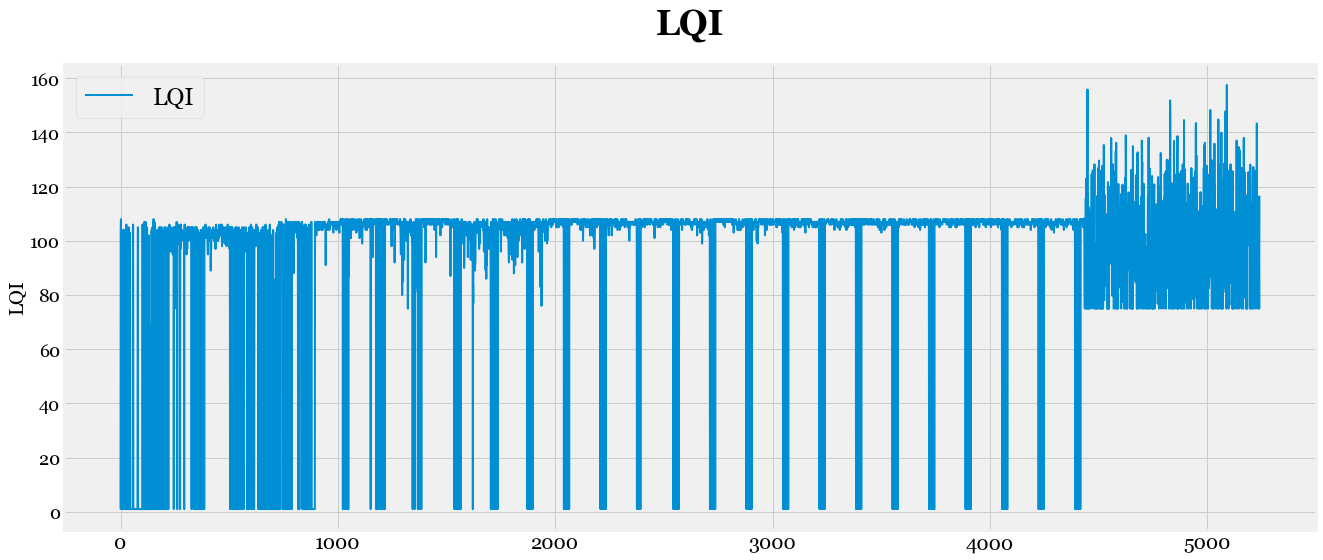

In [25]:
# Sales
smoothed = sales.rolling(window=6).mean()
smoothed = smoothed.dropna()

fig, ax = plt.subplots(figsize=(20,8))

ax.set_title('LQI', fontsize=35, fontweight='bold', pad=30)
ax.set_ylabel('LQI', fontsize=20)
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

for t in ax.xaxis.get_major_ticks():
    t.label.set_fontsize(20) 

df['LQI'].plot(ax=ax, linewidth=2, label="LQI")
ax.legend(fontsize=24)

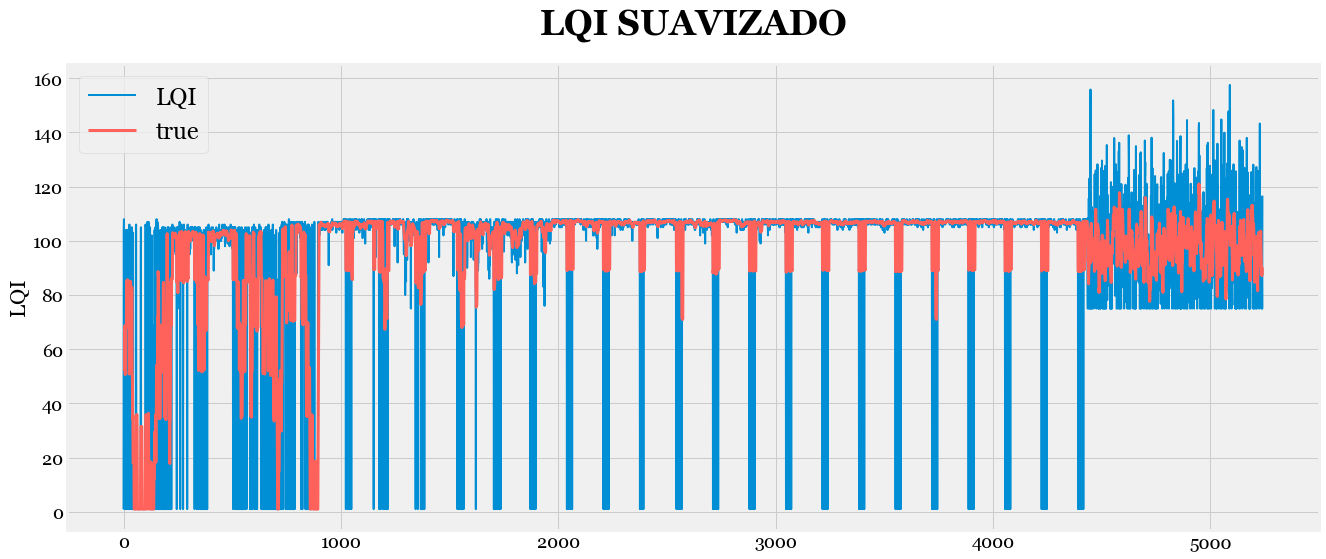

In [26]:
# Total Sales with Smoothing
smoothed = sales.rolling(window=6).mean()
smoothed = smoothed.dropna()

fig, ax = plt.subplots(figsize=(20,8))

ax.set_title('LQI SUAVIZADO', fontsize=35, fontweight='bold', pad=30)
ax.set_ylabel('LQI')
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

sales.plot(ax=ax, linewidth=2, label="LQI")
smoothed.plot(ax=ax, linewidth=3, color='#FF625B', label="true")

ax.legend(fontsize=24)

Text(0.5, 1.0, 'Distribution of groups of 30')

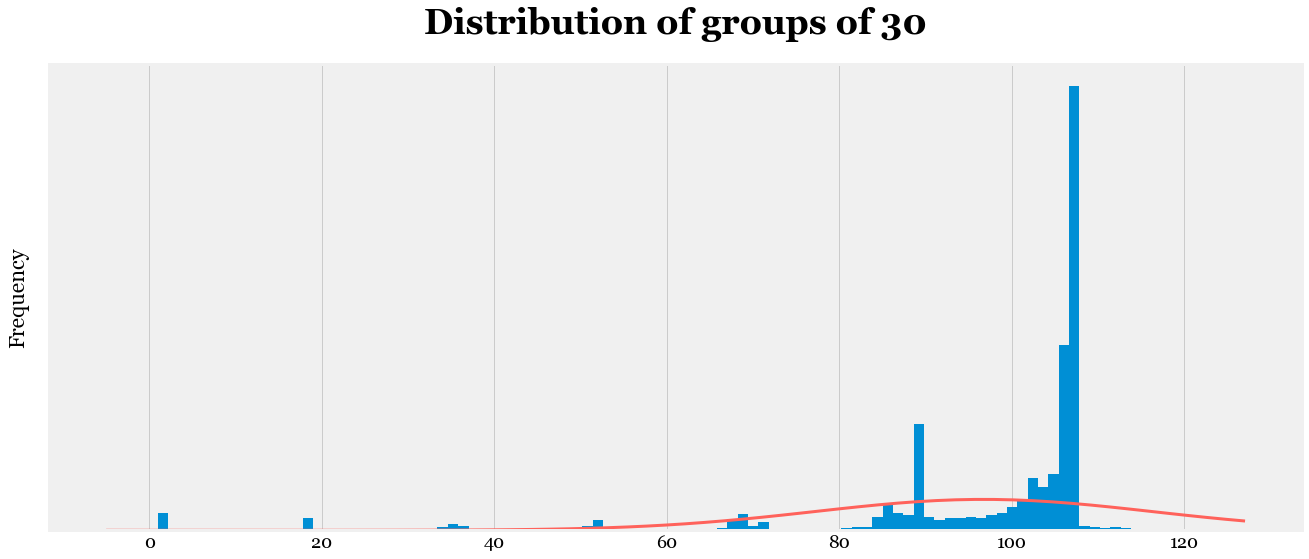

In [27]:
# Distribution of Weekly Sales
fig, ax = plt.subplots(figsize=(20,8))

smoothed.plot.hist(bins=100, density=True, ax=ax)

# Plot the pdf
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 60)
p = norm.pdf(x, smoothed.mean(), smoothed.std())
ax.plot(x, p, color='#FF625B', linewidth=3)
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

ax.set_yticks([])
ax.set_ylabel('Frequency', labelpad=20)
ax.set_title('Distribution of groups of 30', fontsize=35, fontweight='bold', pad=30)

Text(0.5, 1.05, 'Simulate Random Walks')

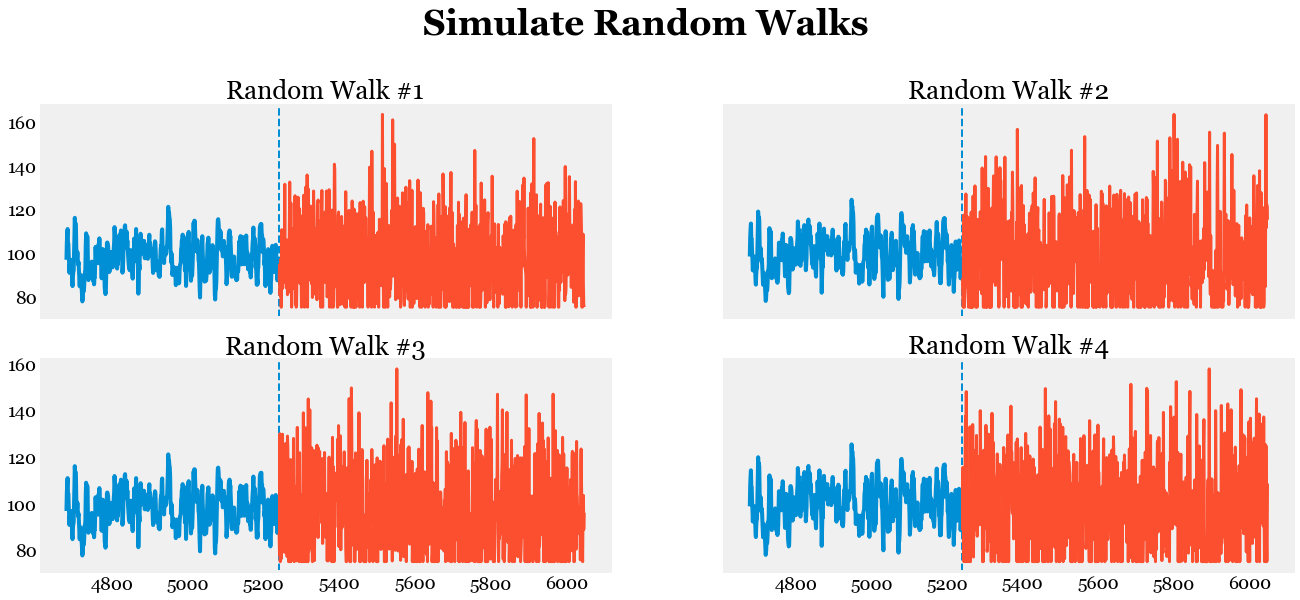

In [28]:
# A random walk
last_sale = smoothed[entrenamiento2-1]
num_weeks = testing1

mu = smoothed.mean()
std = smoothed.std()

index = range(entrenamiento2,entrenamiento3)

def make_sim_plot(ax=ax, title=''):
    sales_series = []
    sales_series.append(last_sale)

    for week in range(num_weeks):
        weekly_sales = np.random.normal(mu, std)
        if weekly_sales < 75:
            weekly_sales = 75;
        sales_series.append(weekly_sales)
    s = pd.Series(sales_series, index=index)
    ax.set_title(title)
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
    ax.axvline(x=s.index.min(), linestyle='dashed', linewidth=2)

    smoothed[-562:].plot(ax=ax)
    s.plot(ax=ax, linewidth=3)

    
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2, figsize=(20,8))

make_sim_plot(ax1, title='Random Walk #1')
make_sim_plot(ax2, title='Random Walk #2')
make_sim_plot(ax3, title='Random Walk #3')
make_sim_plot(ax4, title='Random Walk #4')
ax2.set_yticks([])
ax4.set_yticks([])
ax2.set_xticks([])
ax2.set_xlabel('')
ax1.set_xticks([])
ax1.set_xlabel('')

ax1.grid(None)
ax2.grid(None)
ax3.grid(None)
ax4.grid(None)

fig.suptitle('Simulate Random Walks', fontsize=35, fontweight='bold', y=1.05)

In [29]:
num_simulations = 50000  #n simulaciones

# Creating an array, 
price_list = np.zeros((testing1,num_simulations))
price_list[0]=smoothed[entrenamiento2-1]
price_list

array([[87.30811332, 87.30811332, 87.30811332, ..., 87.30811332,
        87.30811332, 87.30811332],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Text(0.5, 0.98, 'Simulations of 1,000 Random Walks')

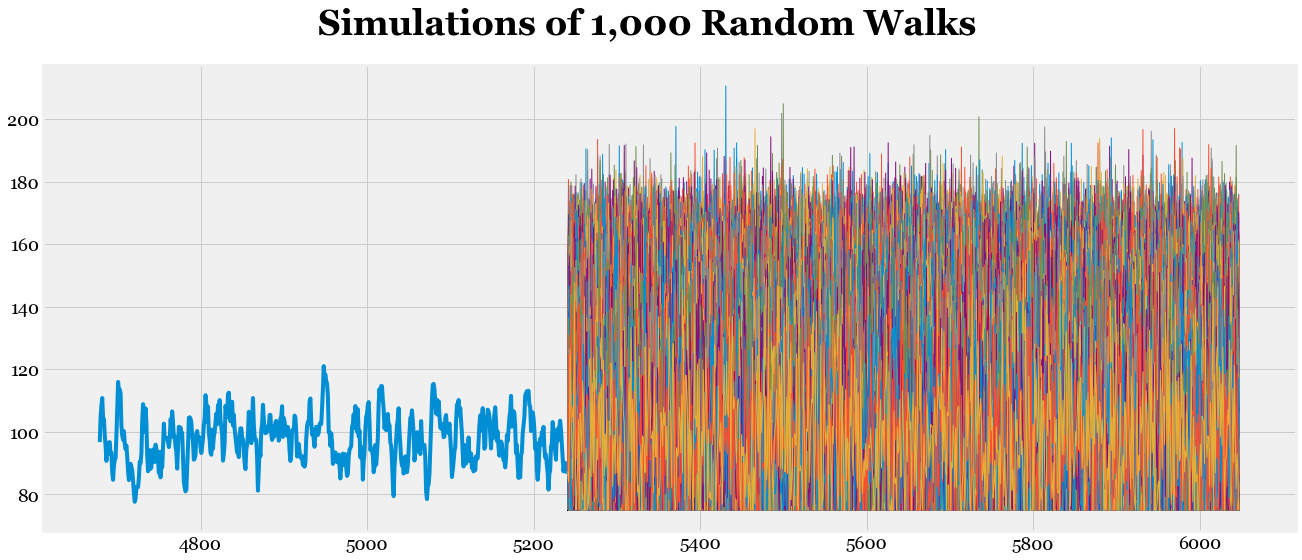

In [30]:
# Many, many random walks
num_simulations = 50000   #n simulaciones
iterations=num_simulations
num_weeks = testing1

last_sale = smoothed[entrenamiento2-1]
mu = smoothed.mean()
std = smoothed.std()

index = range(entrenamiento2,entrenamiento3)

simulation_df = pd.DataFrame()


sales_2018 = []

for sim in range(num_simulations):
    sales_series = []
    sales_series.append(last_sale)

    for week in range(num_weeks):
        weekly_sales = np.random.normal(mu, std)
        if weekly_sales < 75:
            weekly_sales = 75
        #aprovechar el for de semanas para llenar una matriz con las predicciones
        price_list[week,sim]=weekly_sales;
        #print( price_list[week,sim]);
        sales_series.append(weekly_sales)
    
    sales_2018.append(np.sum(sales_series))
    
    simulation_df[sim] = sales_series
    

simulation_df.index = index


fig, ax = plt.subplots(figsize=(20,8))
smoothed[-562:].plot(ax=ax)
simulation_df.plot(ax=ax, legend=False, linewidth=1)

ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
fig.suptitle('Simulations of 1,000 Random Walks', fontsize=35, fontweight='bold')

Text(0.5, 0.98, 'Total LQI FORECAST')

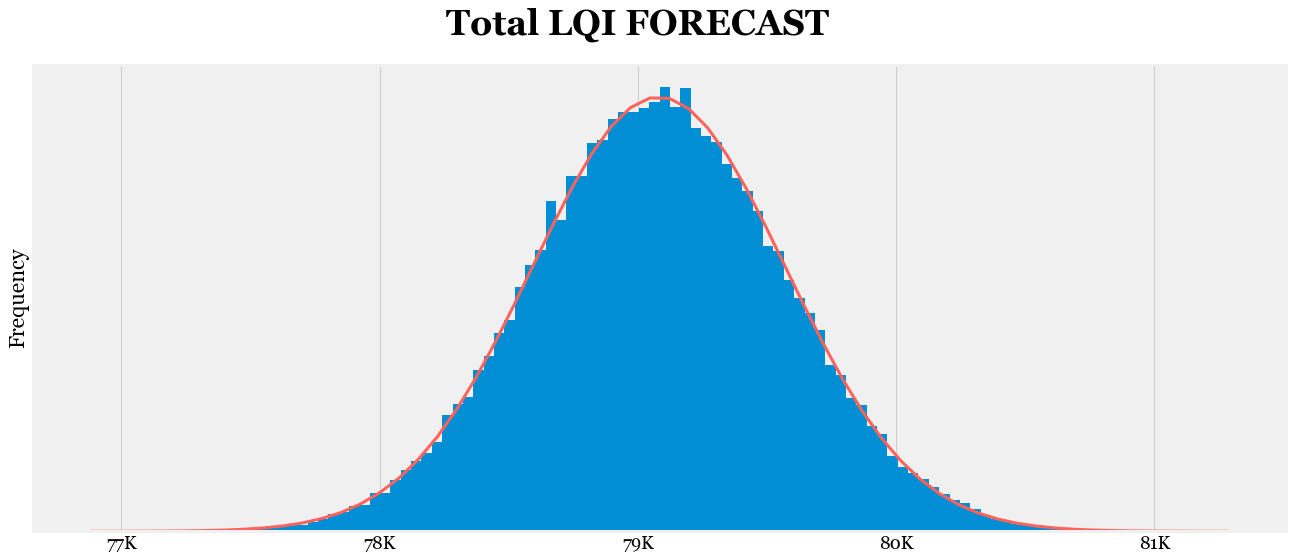

In [31]:
#Random walk total sales

fig, ax = plt.subplots(figsize=(20,8))
simulations_2018 = pd.Series(data=sales_2018)
simulations_2018.plot.hist(bins=100, ax=ax, density=True)

# Plot the pdf
xmin, xmax = plt.xlim()
mean = simulations_2018.mean()
std = simulations_2018.std()

x = np.linspace(xmin, xmax, 60)
p = norm.pdf(x, mean, std)
ax.plot(x, p, color='#FF625B', linewidth=3)
ax.set_yticks([])
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
fig.suptitle('Total LQI FORECAST', fontsize=35, fontweight='bold')

Text(0.5, 0.98, 'TOTAL LQI FORECAST Normal Distribution')

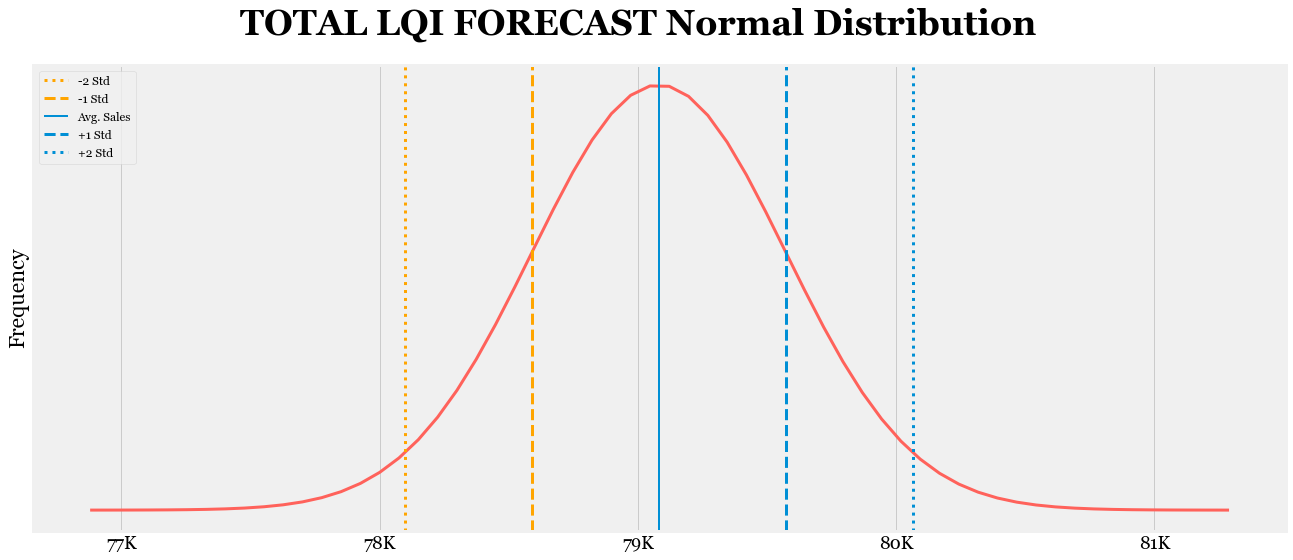

In [32]:
# 2018 Sales normal distribution
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(x, p, color='#FF625B', linewidth=3)

ax.set_yticks([])
ax.set_ylabel('Frequency')

ax.axvline(mean - (std * 2), linewidth=3, label='-2 Std', linestyle='dotted', color='orange')
ax.axvline(mean - std, linewidth=3, label='-1 Std', linestyle='dashed', color='orange')
ax.axvline(mean, linewidth=2, label="Avg. Sales")
ax.axvline(mean + std, linewidth=3, label='+1 Std', linestyle='dashed')
ax.axvline(mean + (std * 2), linewidth=3, label='+2 Std', linestyle='dotted')

ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax.legend(fontsize=12, loc='upper left')
fig.suptitle('TOTAL LQI FORECAST Normal Distribution', fontsize=35, fontweight='bold')

In [33]:
# Ask Questions

from scipy.stats import norm
#mean + std * norm.
#mean + (std * norm.ppf(.25))
print("It's highly likely that you LQI will be between ${:,.0f} and ${:,.0f}.".format(mean + (2 * -std), mean + (2 * std)))
print("There's a 25% chance that LQI will be less than {:,.0f}.".format(mean + (std * norm.ppf(.25))))

It's highly likely that you LQI will be between $78,099 and $80,064.
There's a 25% chance that LQI will be less than 78,750.


In [34]:
simulation_df

,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
5241,87.308113,87.308113,87.308113,87.308113,87.308113,87.308113,87.308113,87.308113,87.308113,87.308113,...,87.308113,87.308113,87.308113,87.308113,87.308113,87.308113,87.308113,87.308113,87.308113,87.308113
5242,106.284363,82.308898,136.811879,97.235304,143.711840,77.692552,75.000000,100.888394,98.643882,123.266622,...,89.159211,121.927124,108.061464,90.224612,124.579672,108.691734,76.920620,75.000000,124.633370,84.017878
5243,78.994076,97.911185,96.437793,90.987526,101.339233,86.246671,129.038299,89.762714,93.025021,112.569773,...,117.097320,105.537491,106.941349,94.740883,97.374814,102.584208,90.206342,108.099999,79.021648,98.331169
5244,90.960423,91.218048,103.194348,76.877513,103.703400,88.570466,101.685532,81.514865,75.875715,81.087367,...,93.363149,95.935773,106.290954,126.496034,95.898732,108.830824,107.761814,112.060891,108.512191,124.251099
5245,97.020977,124.948533,86.573706,94.205512,97.930958,90.764262,91.505569,117.011726,110.667983,126.317869,...,78.499718,75.000000,106.381380,103.307401,75.000000,88.008993,91.789813,75.354609,106.676457,106.386527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043,105.371110,80.117658,101.676339,102.596216,75.000000,139.587119,84.870860,92.351213,75.000000,75.000000,...,93.425755,124.255688,84.189674,75.000000,75.000000,109.970391,132.517628,75.000000,103.379599,96.284121
6044,97.567597,101.292543,120.510757,105.274023,88.816777,135.987459,90.678043,93.589038,102.778399,105.960095,...,110.380762,89.279594,75.000000,84.732342,75.000000,113.754434,75.000000,76.486106,75.000000,81.941045
6045,114.194376,75.000000,128.221366,75.000000,106.180767,129.952615,108.614993,75.000000,102.729854,80.966297,...,107.661064,83.669982,93.890121,83.742612,81.694855,88.417794,121.390120,115.919634,118.878064,92.929933
6046,115.981604,104.282503,75.000000,78.751505,84.271874,150.961823,75.000000,100.798884,92.565732,89.798279,...,109.313575,100.286916,75.000000,75.000000,77.178478,139.226042,93.291615,78.990020,95.202790,87.208858


In [35]:
#HALLLAR LA MEJOR SIMULACIÓN MEDIANTE RMSE Y plotearla con una cantidad de datos de test

# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 

#for para comparar todas las predicciones

menor=5;
index=0;

for i in range(0, iterations):
    prediction = rmse(test["LQI"], price_list[:, i]) 
    if prediction<menor:
        menor=prediction
        index=i
        
        
print(menor, index)

5 0


In [36]:
#unir el training 0-55% con la prediccion 55-65%

In [37]:
#convertir a dataframe las predicciones
predictions2=pd.DataFrame(price_list[:,index])
predictions2

,0
0,106.284363
1,78.994076
2,90.960423
3,97.020977
4,85.810961
...,...
801,105.371110
802,97.567597
803,114.194376
804,115.981604


In [38]:
#renombrar la columna para poder concatenar
predictions2=predictions2.rename(columns={0:'LQI'})
predictions2

,LQI
0,106.284363
1,78.994076
2,90.960423
3,97.020977
4,85.810961
...,...
801,105.371110
802,97.567597
803,114.194376
804,115.981604


In [39]:
train3 = pd.concat([df,predictions2])
train3=train3.reset_index(drop=True)  #reseteo index
train3

,LQI
0,1.000000
1,104.000000
2,108.000000
3,1.000000
4,1.000000
...,...
6042,105.371110
6043,97.567597
6044,114.194376
6045,115.981604


In [40]:
#Realizo el tercer entrenamiento de 0-75 para predecir 75-100
#datos de entrenamiento y testing con Walk Forward Validation 
df=train3
sales = df['LQI']

test=dfs[entrenamiento3:cantidad]
test=test.reset_index(drop="true")

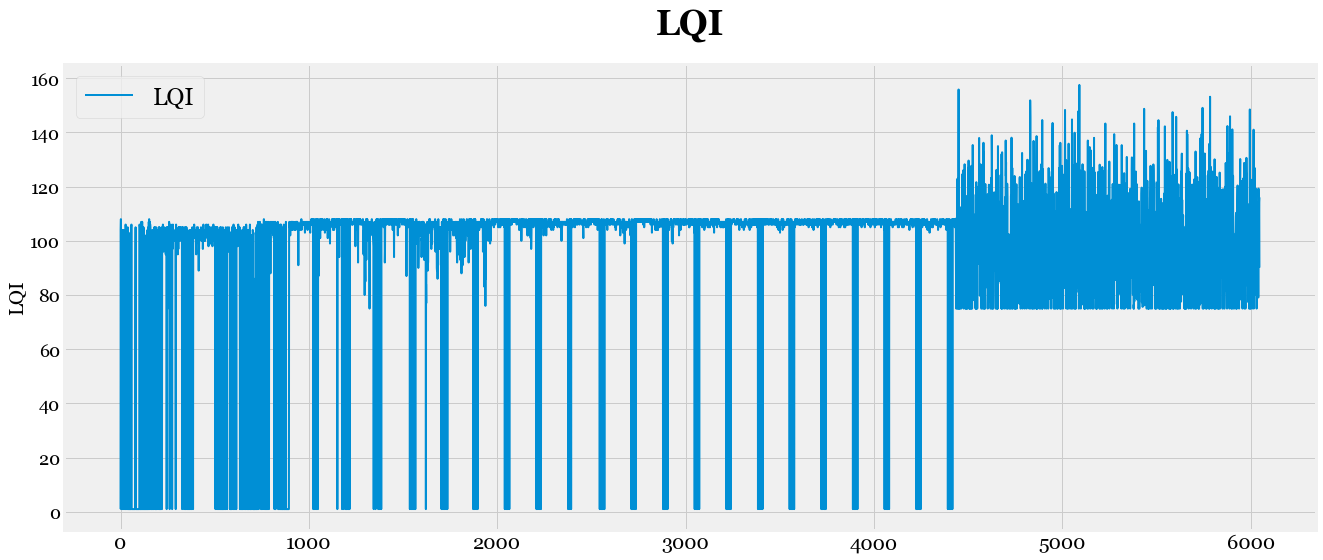

In [41]:
# Sales
smoothed = sales.rolling(window=6).mean()
smoothed = smoothed.dropna()

fig, ax = plt.subplots(figsize=(20,8))

ax.set_title('LQI', fontsize=35, fontweight='bold', pad=30)
ax.set_ylabel('LQI', fontsize=20)
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

for t in ax.xaxis.get_major_ticks():
    t.label.set_fontsize(20) 

df['LQI'].plot(ax=ax, linewidth=2, label="LQI")
ax.legend(fontsize=24)

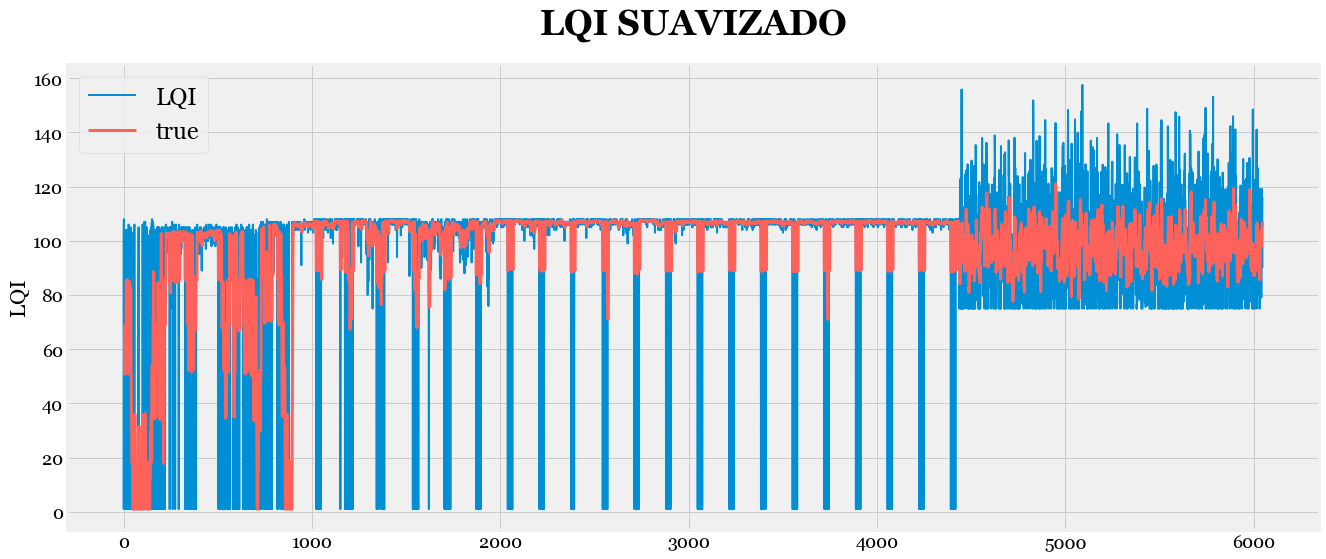

In [42]:
# Total Sales with Smoothing
smoothed = sales.rolling(window=6).mean()
smoothed = smoothed.dropna()

fig, ax = plt.subplots(figsize=(20,8))

ax.set_title('LQI SUAVIZADO', fontsize=35, fontweight='bold', pad=30)
ax.set_ylabel('LQI')
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

sales.plot(ax=ax, linewidth=2, label="LQI")
smoothed.plot(ax=ax, linewidth=3, color='#FF625B', label="true")

ax.legend(fontsize=24)

Text(0.5, 1.0, 'Distribution of groups of 30')

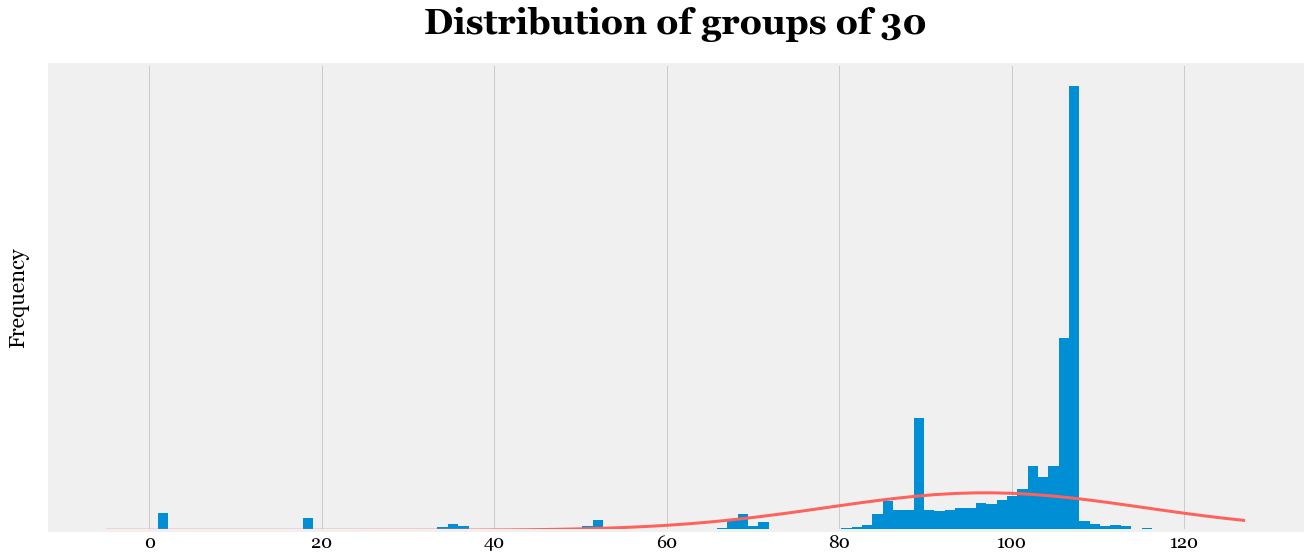

In [43]:
# Distribution of Weekly Sales
fig, ax = plt.subplots(figsize=(20,8))

smoothed.plot.hist(bins=100, density=True, ax=ax)

# Plot the pdf
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 60)
p = norm.pdf(x, smoothed.mean(), smoothed.std())
ax.plot(x, p, color='#FF625B', linewidth=3)
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

ax.set_yticks([])
ax.set_ylabel('Frequency', labelpad=20)
ax.set_title('Distribution of groups of 30', fontsize=35, fontweight='bold', pad=30)

Text(0.5, 1.05, 'Simulate Random Walks')

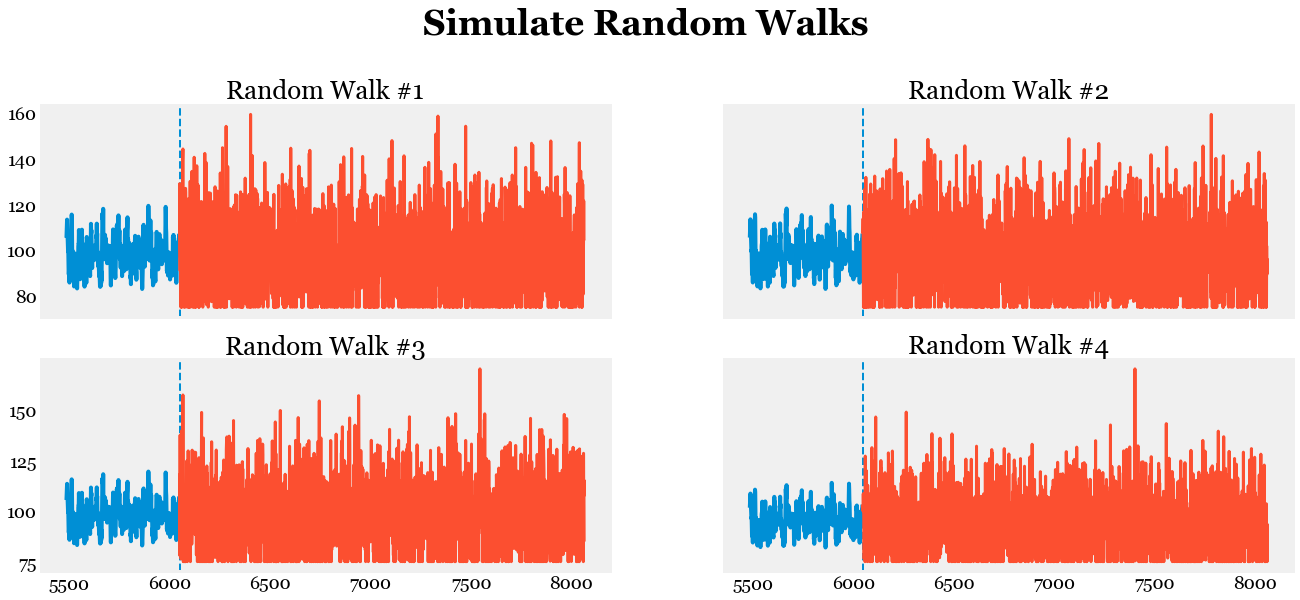

In [44]:
# A random walk
last_sale = smoothed[entrenamiento3-2]
num_weeks = testing2-1

mu = smoothed.mean()
std = smoothed.std()

index = range(entrenamiento3,cantidad)

def make_sim_plot(ax=ax, title=''):
    sales_series = []
    sales_series.append(last_sale)

    for week in range(num_weeks):
        weekly_sales = np.random.normal(mu, std)
        if weekly_sales < 75:
            weekly_sales = 75;
        sales_series.append(weekly_sales)
    s = pd.Series(sales_series, index=index)
    ax.set_title(title)
    ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
    ax.axvline(x=s.index.min(), linestyle='dashed', linewidth=2)

    smoothed[-562:].plot(ax=ax)
    s.plot(ax=ax, linewidth=3)

    
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2, figsize=(20,8))

make_sim_plot(ax1, title='Random Walk #1')
make_sim_plot(ax2, title='Random Walk #2')
make_sim_plot(ax3, title='Random Walk #3')
make_sim_plot(ax4, title='Random Walk #4')
ax2.set_yticks([])
ax4.set_yticks([])
ax2.set_xticks([])
ax2.set_xlabel('')
ax1.set_xticks([])
ax1.set_xlabel('')

ax1.grid(None)
ax2.grid(None)
ax3.grid(None)
ax4.grid(None)

fig.suptitle('Simulate Random Walks', fontsize=35, fontweight='bold', y=1.05)

In [45]:
num_simulations = 50000  #n simulaciones

# Creating an array, 
price_list = np.zeros((testing2,num_simulations))
price_list[0]=smoothed[entrenamiento3-2]
price_list

array([[107.08782233, 107.08782233, 107.08782233, ..., 107.08782233,
        107.08782233, 107.08782233],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

Text(0.5, 0.98, 'Simulations of 1,000 Random Walks')

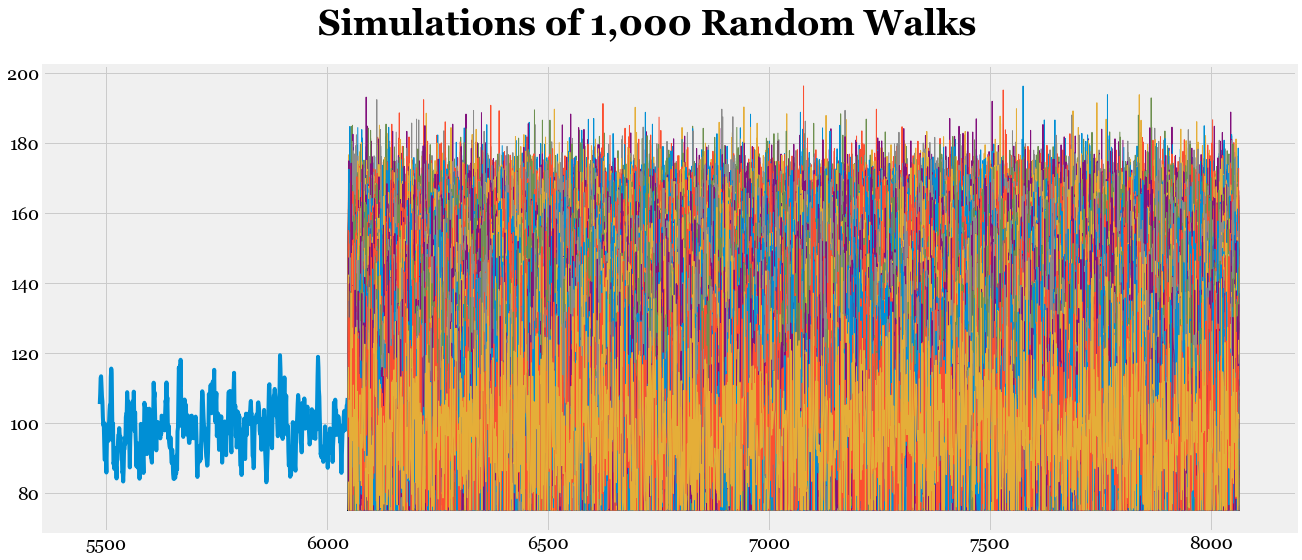

In [46]:
# Many, many random walks
num_simulations = 50000   #n simulaciones
iterations=num_simulations
num_weeks = testing2

last_sale = smoothed[entrenamiento3-2]
mu = smoothed.mean()
std = smoothed.std()

index = range(entrenamiento3-1,cantidad)

simulation_df = pd.DataFrame()


sales_2018 = []

for sim in range(num_simulations):
    sales_series = []
    sales_series.append(last_sale)

    for week in range(num_weeks):
        weekly_sales = np.random.normal(mu, std)
        if weekly_sales < 75:
            weekly_sales = 75
        #aprovechar el for de semanas para llenar una matriz con las predicciones
        price_list[week,sim]=weekly_sales;
        #print( price_list[week,sim]);
        sales_series.append(weekly_sales)
    
    sales_2018.append(np.sum(sales_series))
    
    simulation_df[sim] = sales_series
    

simulation_df.index = index


fig, ax = plt.subplots(figsize=(20,8))
smoothed[-562:].plot(ax=ax)
simulation_df.plot(ax=ax, legend=False, linewidth=1)

ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
fig.suptitle('Simulations of 1,000 Random Walks', fontsize=35, fontweight='bold')

Text(0.5, 0.98, 'Total LQI FORECAST')

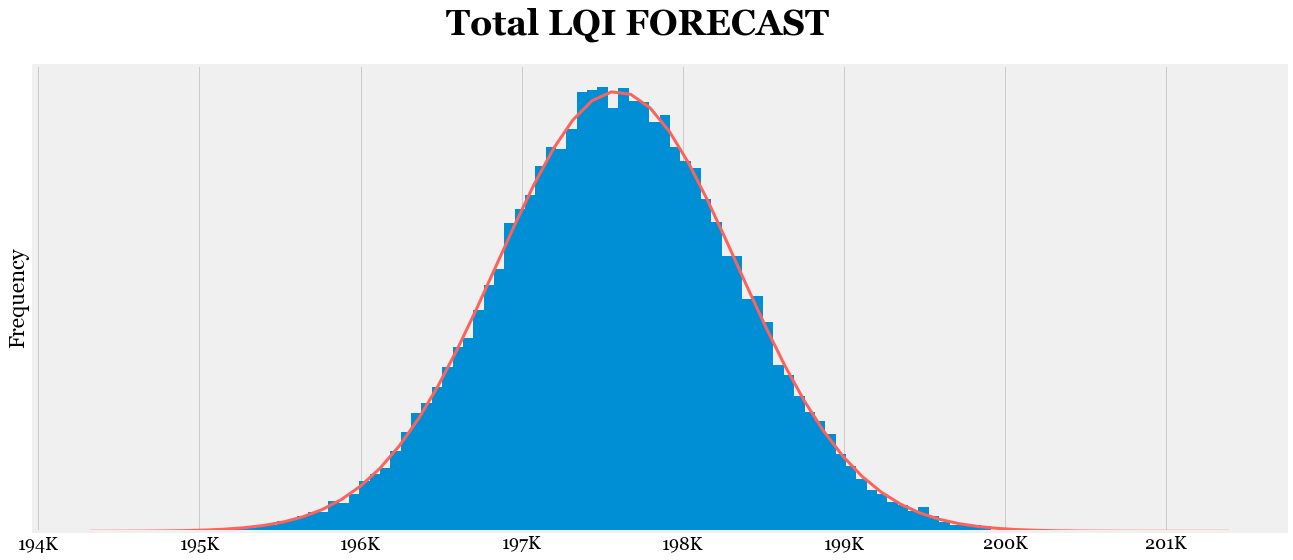

In [47]:
#Random walk total sales

fig, ax = plt.subplots(figsize=(20,8))
simulations_2018 = pd.Series(data=sales_2018)
simulations_2018.plot.hist(bins=100, ax=ax, density=True)

# Plot the pdf
xmin, xmax = plt.xlim()
mean = simulations_2018.mean()
std = simulations_2018.std()

x = np.linspace(xmin, xmax, 60)
p = norm.pdf(x, mean, std)
ax.plot(x, p, color='#FF625B', linewidth=3)
ax.set_yticks([])
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
fig.suptitle('Total LQI FORECAST', fontsize=35, fontweight='bold')

Text(0.5, 0.98, 'TOTAL LQI FORECAST Normal Distribution')

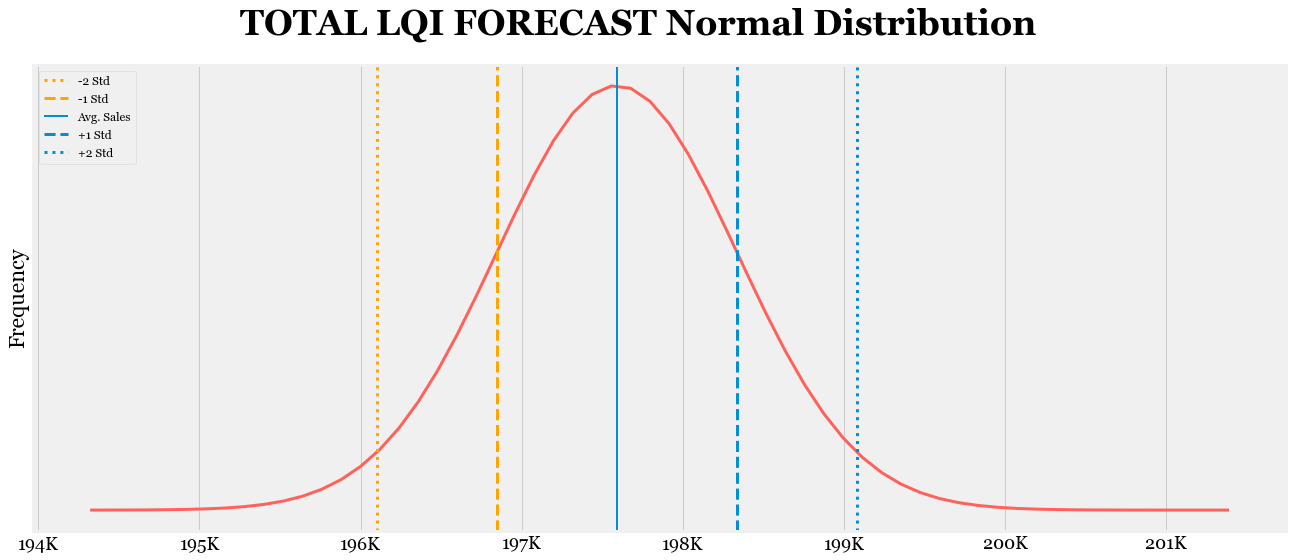

In [48]:
# 2018 Sales normal distribution
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(x, p, color='#FF625B', linewidth=3)

ax.set_yticks([])
ax.set_ylabel('Frequency')

ax.axvline(mean - (std * 2), linewidth=3, label='-2 Std', linestyle='dotted', color='orange')
ax.axvline(mean - std, linewidth=3, label='-1 Std', linestyle='dashed', color='orange')
ax.axvline(mean, linewidth=2, label="Avg. Sales")
ax.axvline(mean + std, linewidth=3, label='+1 Std', linestyle='dashed')
ax.axvline(mean + (std * 2), linewidth=3, label='+2 Std', linestyle='dotted')

ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax.legend(fontsize=12, loc='upper left')
fig.suptitle('TOTAL LQI FORECAST Normal Distribution', fontsize=35, fontweight='bold')

In [49]:
# Ask Questions

from scipy.stats import norm
#mean + std * norm.
#mean + (std * norm.ppf(.25))
print("It's highly likely that you LQI will be between ${:,.0f} and ${:,.0f}.".format(mean + (2 * -std), mean + (2 * std)))
print("There's a 25% chance that LQI will be less than {:,.0f}.".format(mean + (std * norm.ppf(.25))))

It's highly likely that you LQI will be between $196,100 and $199,083.
There's a 25% chance that LQI will be less than 197,088.


In [50]:
simulation_df

,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
6047,107.087822,107.087822,107.087822,107.087822,107.087822,107.087822,107.087822,107.087822,107.087822,107.087822,...,107.087822,107.087822,107.087822,107.087822,107.087822,107.087822,107.087822,107.087822,107.087822,107.087822
6048,100.084318,87.238939,86.932458,95.656867,102.123082,97.665197,96.622666,78.465246,82.110308,97.360463,...,110.682441,120.518777,113.198551,75.000000,119.561717,90.524458,109.943852,100.340474,95.991942,115.809191
6049,82.632779,121.151132,82.513429,121.096112,110.376051,81.450679,99.722013,99.921513,89.197091,80.819934,...,83.375225,105.844930,130.084311,75.000000,106.501744,106.118290,83.225507,111.036429,120.296655,101.557065
6050,103.864485,75.000000,101.619514,86.369450,107.437879,131.874874,100.146197,103.320727,100.687449,109.846813,...,82.576047,103.635769,126.280575,88.644722,114.707409,99.592248,112.871471,99.331052,98.305548,106.461904
6051,122.332663,114.759158,75.000000,103.694105,112.932385,127.530725,122.111191,94.074973,77.674388,104.751335,...,99.750087,92.849573,75.651713,84.653980,112.800835,88.688407,75.000000,90.385580,118.929556,81.674768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8059,110.908270,118.273422,89.260232,99.482513,75.000000,127.595576,93.462987,87.695481,88.714019,96.560389,...,93.926309,91.676397,111.390311,127.689103,134.621368,119.078227,106.438676,75.000000,115.523014,87.221718
8060,81.050185,87.234708,98.354969,149.366901,84.057611,87.799294,115.721991,90.078231,100.422915,100.571805,...,109.392549,75.000000,136.277452,94.371039,92.441861,122.749418,130.338218,75.000000,97.118340,102.953587
8061,75.000000,78.363722,93.615680,81.268665,94.481962,79.504498,105.799119,102.722279,119.712689,106.130336,...,75.000000,76.228633,87.478751,97.412370,82.578507,94.827674,103.468479,76.800364,95.505142,75.000000
8062,91.324031,93.512012,107.657374,111.356515,104.443023,127.525561,90.864891,117.582256,75.039941,109.943702,...,100.712305,97.117648,104.465735,123.646027,76.218925,104.122773,108.487674,109.163886,116.125213,102.505870


In [51]:
#HALLLAR LA MEJOR SIMULACIÓN MEDIANTE RMSE Y plotearla con una cantidad de datos de test

# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 

#for para comparar todas las predicciones

menor=50;
index=0;

for i in range(0, iterations):
    prediction = rmse(test["LQI"], price_list[:, i]) 
    if prediction<menor:
        menor=prediction
        index=i
        
        
print(menor, index)

22.488688083676227 13557


In [52]:
# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 


#métricas
prediction1 = price_list[:, index];
rmse(test["LQI"], prediction1) 


# Calculate mean squared error 
mse = mean_squared_error(test["LQI"], prediction1)
print("MSE: ")
print(mse)

# Calculate root mean squared error 
rmse = rmse(test["LQI"], prediction1)
print("\nRMSE: ")
print(rmse)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape =  mean_absolute_percentage_error(test["LQI"], prediction1)
print("\nMAPE (Porcentaje): ")
print(mape)

MSE: 
505.7410917248811

RMSE: 
22.488688083676227

MAPE (Porcentaje): 
235.93903885703003


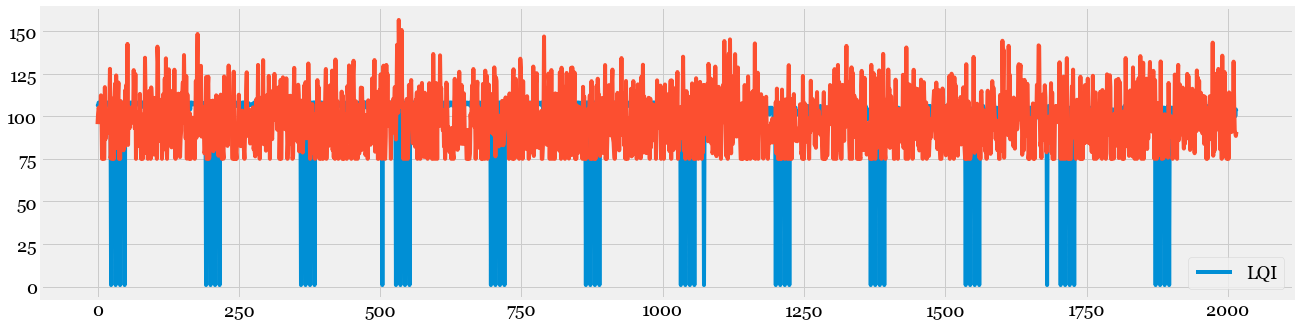

In [53]:
bp = price_list[:,index];

test.plot(figsize = (20, 5), label="true");
plt.plot(bp, label="forecast");